In [1]:
!pip install -q pycocotools matplotlib

In [2]:
import kagglehub
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Path to dataset files: /kaggle/input/coco-2017-dataset


Generating binary masks


build_masks:   0%|          | 0/5000 [00:00<?, ?it/s]

Total=5000, train=4800, val=200, device=cuda
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:00<00:00, 201MB/s]


train ep1:   0%|          | 0/800 [00:00<?, ?it/s]

train ep2:   0%|          | 0/800 [00:00<?, ?it/s]

train ep3:   0%|          | 0/800 [00:00<?, ?it/s]

train ep4:   0%|          | 0/800 [00:00<?, ?it/s]

train ep5:   0%|          | 0/800 [00:00<?, ?it/s]

train ep6:   0%|          | 0/800 [00:00<?, ?it/s]

train ep7:   0%|          | 0/800 [00:00<?, ?it/s]

train ep8:   0%|          | 0/800 [00:00<?, ?it/s]

train ep9:   0%|          | 0/800 [00:00<?, ?it/s]

train ep10:   0%|          | 0/800 [00:00<?, ?it/s]

train ep11:   0%|          | 0/800 [00:00<?, ?it/s]

train ep12:   0%|          | 0/800 [00:00<?, ?it/s]

train ep13:   0%|          | 0/800 [00:00<?, ?it/s]

train ep14:   0%|          | 0/800 [00:00<?, ?it/s]

train ep15:   0%|          | 0/800 [00:00<?, ?it/s]

final-eval:   0%|          | 0/34 [00:00<?, ?it/s]

PIXEL ACCURACY: 0.8502
IOU MEAN: 0.6199
DICE MEAN: 0.7653


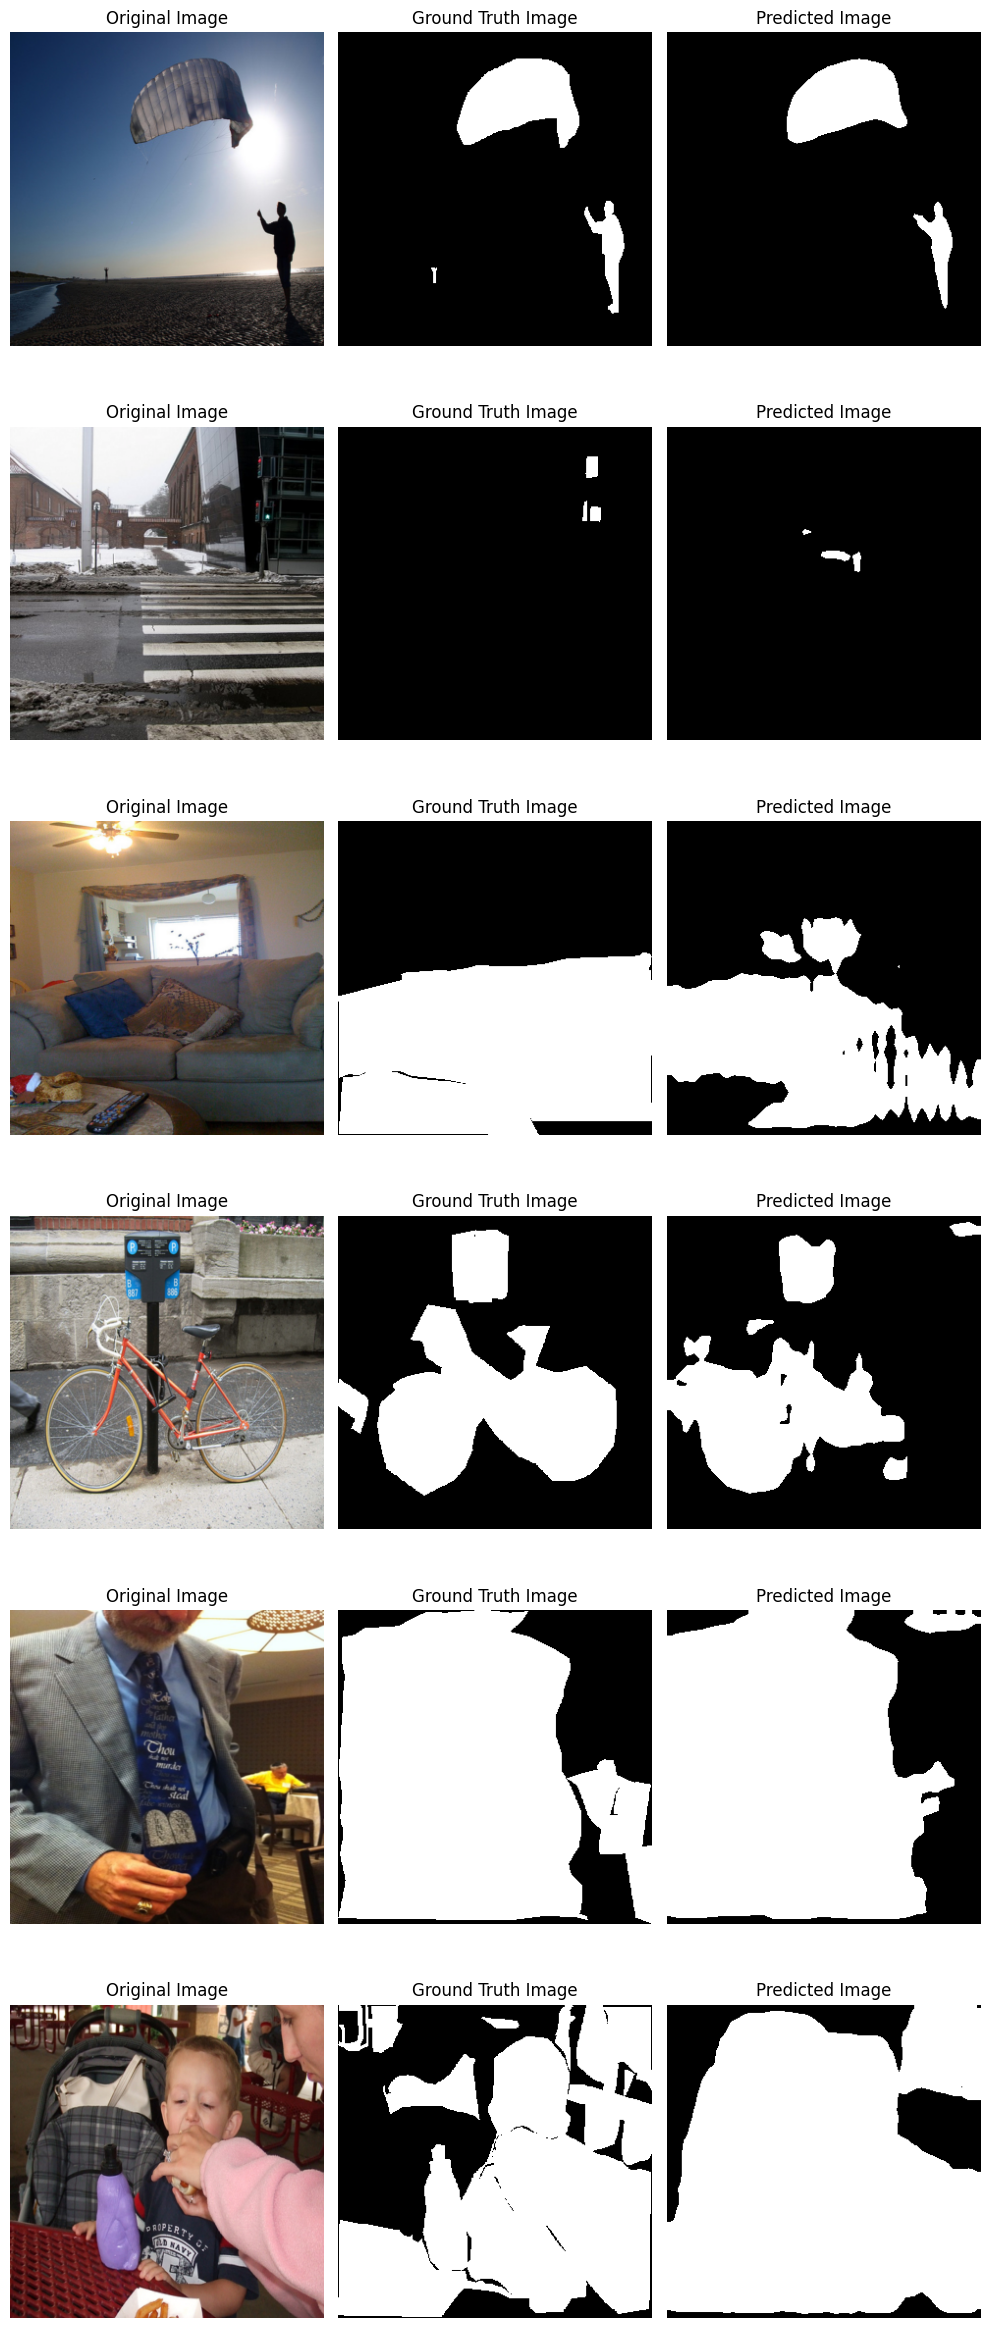

In [3]:
IMAGES_DIR = '/kaggle/input/coco-2017-dataset/coco2017/val2017'
ANNOTATIONS_JSON = '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json'
OUTPUT_DIR = 'segmentation_outputs'
IMG_SIZE=(320,320)
BATCH=6
LR=2e-4
EPOCHS=15
TH=0.5
VAL_PORTION=0.1

import os, json, numpy as np
from pathlib import Path
from PIL import Image
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as T
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPyImage

device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def build_masks(ann_json, imgs_dir, out_dir):
    from pycocotools import mask as maskUtils
    out = Path(out_dir)/'masks'; out.mkdir(parents=True,exist_ok=True)
    coco = json.load(open(ann_json)); id2f = {i['id']:i['file_name'] for i in coco['images']}
    ann_map = {}
    for a in coco['annotations']: ann_map.setdefault(a['image_id'],[]).append(a)
    for img_id,fname in tqdm(id2f.items(), desc='build_masks'):
        p = Path(imgs_dir)/fname
        if not p.exists(): continue
        meta = next((i for i in coco['images'] if i['id']==img_id), {})
        w,h = meta.get('width'), meta.get('height')
        if not w: w,h = Image.open(p).size
        mask = np.zeros((h,w),dtype=np.uint8)
        for a in ann_map.get(img_id,[]):
            seg = a.get('segmentation')
            if not seg:
                bbox=a.get('bbox')
                if bbox:
                    x,y,bw,bh = map(int,bbox); mask[y:y+bh,x:x+bw]=1
                continue
            try:
                rle = maskUtils.frPyObjects(seg,h,w) if isinstance(seg,list) else seg
                m = maskUtils.decode(rle)
            except:
                bbox=a.get('bbox')
                if bbox:
                    x,y,bw,bh = map(int,bbox); mask[y:y+bh,x:x+bw]=1
                continue
            if m.ndim==3: m = m.max(axis=2)
            mask = np.maximum(mask, m)
        Image.fromarray((mask*255).astype('uint8')).save(out/(Path(fname).stem + '.png'))
    return str(out)

import warnings
warnings.filterwarnings("ignore")
class SimpleCOCO(Dataset):
    def __init__(self, imgs_dir, masks_dir, size):
        self.files = sorted([p for p in Path(imgs_dir).iterdir() if p.suffix.lower() in ('.jpg','.jpeg','.png')])
        self.masks_dir = Path(masks_dir)
        self.timg = T.Compose([T.Resize(size), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
        self.tmask = T.Compose([T.Resize(size, interpolation=Image.NEAREST)])
    def __len__(self): return len(self.files)
    def __getitem__(self,i):
        p=self.files[i]; m=self.masks_dir/(p.stem+'.png')
        img=Image.open(p).convert('RGB'); mask=Image.open(m).convert('L') if m.exists() else Image.new('L', img.size)
        it=self.timg(img); mt=self.tmask(mask); mt=torch.from_numpy(np.array(mt)/255.).float().unsqueeze(0)
        return it, mt

masks_dir = Path(OUTPUT_DIR)/'seg_masks'/'masks'
if not masks_dir.exists() or len(list(masks_dir.glob('*.png')))==0:
    print("Generating binary masks")
    masks_dir_str = build_masks(ANNOTATIONS_JSON, IMAGES_DIR, str(Path(OUTPUT_DIR)/'seg_masks'))
else:
    masks_dir_str = str(masks_dir)

ds = SimpleCOCO(IMAGES_DIR, masks_dir_str, IMG_SIZE)
n=len(ds); assert n>0, "no images"
val_n = min(200, max(1, int(VAL_PORTION * n))); train_n = n - val_n
train_ds, val_ds = torch.utils.data.random_split(ds, [train_n, val_n], generator=torch.Generator().manual_seed(42))
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=(device=='cuda'))
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=(device=='cuda'))
print(f"Total={n}, train={train_n}, val={val_n}, device={device}")

try:
    from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
    model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
except:
    model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
in_ch = getattr(model.classifier[-1],'in_channels', None) or model.classifier[-1].weight.shape[1]
model.classifier[-1] = nn.Conv2d(in_ch,1,kernel_size=1)
model = model.to(device)
bce = nn.BCEWithLogitsLoss(); optimizer = torch.optim.Adam(model.parameters(), lr=LR)
class DiceLoss(nn.Module):
    def __init__(self,eps=1e-7): super().__init__(); self.eps=eps
    def forward(self,logits, target):
        p=torch.sigmoid(logits).view(logits.size(0),-1); t=target.view(target.size(0),-1)
        inter=(p*t).sum(1); denom = p.sum(1)+t.sum(1)
        return 1 - ((2*inter + self.eps)/(denom + self.eps)).mean()
dice_loss = DiceLoss()

from torch.cuda.amp import autocast, GradScaler
use_amp = (device=='cuda'); scaler = GradScaler() if use_amp else None
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb,yb in tqdm(train_dl, desc=f"train ep{epoch}", leave=False):
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        if use_amp:
            with autocast(): out = model(xb)['out']; loss = bce(out,yb) + dice_loss(out,yb)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            out = model(xb)['out']; loss = bce(out,yb) + dice_loss(out,yb)
            loss.backward(); optimizer.step()

model.eval()
g_inter = g_union = g_pred = g_gt = 0
total_correct = total_pixels = 0
with torch.no_grad():
    for xb,yb in tqdm(val_dl, desc='final-eval', leave=True):
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)['out']; probs = torch.sigmoid(out).cpu().numpy(); gts = yb.cpu().numpy().astype(np.uint8)
        preds = (probs > TH).astype(np.uint8)
        total_correct += int((preds == gts).sum()); total_pixels += int(np.prod(gts.shape))
        for i in range(preds.shape[0]):
            p = preds[i,0].astype(bool); g = gts[i,0].astype(bool)
            inter = int((p & g).sum()); union = int((p | g).sum()); ps = int(p.sum()); gs = int(g.sum())
            g_inter += inter; g_union += union; g_pred += ps; g_gt += gs

pix_acc = float(total_correct)/float(total_pixels) if total_pixels else 0.0
iou_global = (g_inter/g_union) if g_union>0 else 1.0
dice_global = (2.0 * g_inter / (g_pred + g_gt)) if (g_pred + g_gt) > 0 else 1.0

print(f"PIXEL ACCURACY: {pix_acc:.4f}")
print(f"IOU MEAN: {iou_global:.4f}")
print(f"DICE MEAN: {dice_global:.4f}")
def inv_norm(t):
    t = t.clone(); t[0]=t[0]*0.229+0.485; t[1]=t[1]*0.224+0.456; t[2]=t[2]*0.225+0.406
    return t.permute(1,2,0).cpu().numpy().clip(0,1)

n_show = min(6, len(val_ds)); idxs = list(np.linspace(0, len(val_ds)-1, n_show, dtype=int))
fig, axs = plt.subplots(n_show, 3, figsize=(10,4*n_show))
if n_show==1: axs = axs[np.newaxis,:]
with torch.no_grad():
    for r, idx in enumerate(idxs):
        img_t, mask_t = val_ds[idx]
        out = model(img_t.unsqueeze(0).to(device))['out'][0]
        pred = (torch.sigmoid(out) > TH).float()[0].cpu().numpy()
        axs[r,0].imshow(inv_norm(img_t)); axs[r,0].axis('off'); axs[r,0].set_title('Original Image')
        axs[r,1].imshow(mask_t.squeeze(0).numpy(), cmap='gray'); axs[r,1].axis('off'); axs[r,1].set_title('Ground Truth Image')
        axs[r,2].imshow(pred, cmap='gray'); axs[r,2].axis('off'); axs[r,2].set_title('Predicted Image')
plt.tight_layout()
savepath = Path(OUTPUT_DIR)/'finalsamplepredictions.png'; plt.savefig(savepath)
